# Multiple Coordinated Views

In [129]:
import altair as alt
import pandas as pd
import numpy as np

In [130]:
flu = pd.read_csv('flunet2010_11countries.csv', header=[0,1])
cols = flu.columns.tolist()
normed = pd.melt(flu, id_vars=[cols[0]], value_vars=cols[1:], var_name=['continent','country'])
normed = normed.rename(columns={normed.columns[0]: 'week'})
normed.head()

,week,continent,country,value
0,1,Asia,Afghanistan,5.0
1,2,Asia,Afghanistan,13.0
2,3,Asia,Afghanistan,4.0
3,4,Asia,Afghanistan,0.0
4,5,Asia,Afghanistan,0.0


## Visualization 1
#### Create Linked Plots Showing Flu Cases per Country and Total Flu Cases per Week
In this example a dropdown selector and a time slider provided by the crosstalk package are linked to two plots.

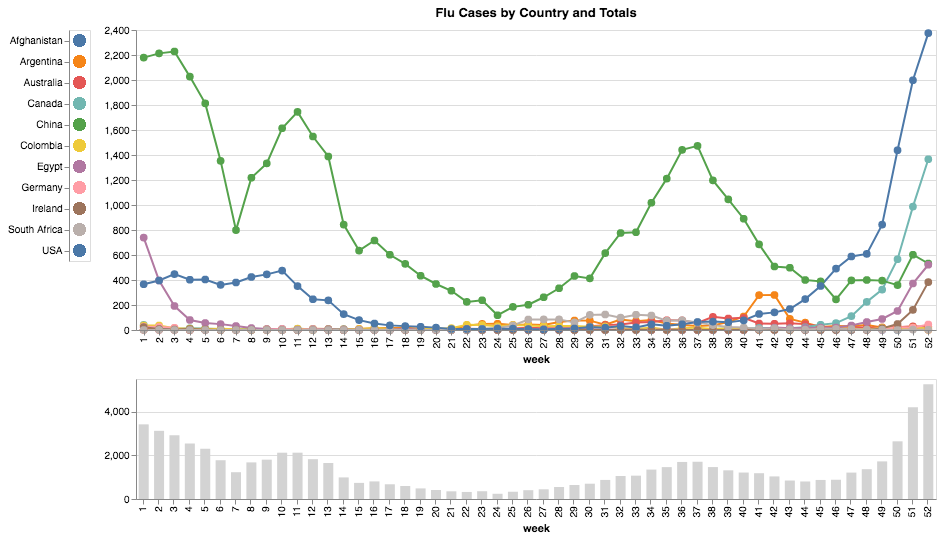

In [131]:
click = alt.selection_multi(encodings=['color'])
brush = alt.selection_interval(encodings=['x'])

line = alt.Chart(normed).mark_line(point=alt.MarkConfig(shape='circle', size=60)).encode(
    x='week:N',
    y=alt.Y('value:Q', title=None),
    color=alt.Color('country:N', legend=None),
    tooltip=['week','value']
).transform_filter(
    brush
).transform_filter(
    click
).properties(
    width=800,
    title='Flu Cases by Country and Totals',
    selection=click
)

hist = alt.Chart(normed).mark_bar(size=10).encode(
    x=alt.X('week:N'),
    y=alt.Y('sum(value):Q', title=None),
    color=alt.value('lightgray'),
    tooltip=['week','sum(value)']
).properties(
    width=800,
    height=120,
).add_selection(
    brush
)

legend = alt.Chart(normed).mark_circle(size=150).encode(
    y=alt.Y('country', title=None),
    color=alt.condition(click, alt.Color('country:N', legend=None), alt.value('lightgray'))
).properties(
    selection=click
)

legend | (line & hist)

#### Selections:
* Click to select individual countries.
* Hold shift and click to select multiple countries.
* Brush barchart to narrow top view.

## Visualization 2
#### Create an Overview+Detail Plot Showing Flu Cases per Country

In this example a checkbox selection is used to control countries of which continents are shown in a stacked bar chart. The stacked bar chart shows flu cases per week and country. The overview+detail visualization is enabled by using the rangeslider property on the x axis of the plot.

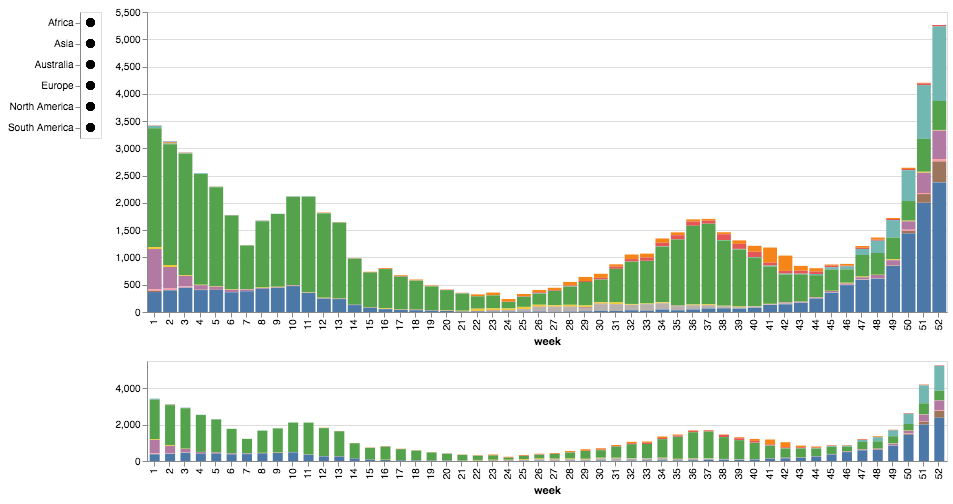

In [132]:
click = alt.selection_multi(encodings=['y'])
brush = alt.selection_interval(encodings=['x'])


bar = alt.Chart(normed).mark_bar().encode(
    alt.Color('country:N', legend=None),
    alt.X('week:N'),
    alt.Y('sum(value)', title=None),
    tooltip=['country']
).transform_filter(
    click
).transform_filter(
    brush
).properties(
    width=800,
)

bar_overview = alt.Chart(normed).mark_bar(size=10).encode(
    alt.X('week:N'),
    alt.Y('sum(value)', title=None),
    alt.Color('country:N', legend=None)
).properties(
    height=100,
    width=800,
    selection=brush
)

legend = alt.Chart(normed).mark_circle(size=60).encode(
    alt.Y('continent:N', title=None),
    color=alt.condition(click, alt.value('black'), alt.value('lightgray'))
).properties(
    selection=click
)

legend | (bar & bar_overview)

## Visualization 3
#### Create Linked Plots Showing Flu Cases per Country per Week and Total Flu Cases per Country
For this visualization we create two linked plots. One that shows flu cases per country per week and a second on that show the total of all flu cases per country.

I created an extra view where you can brush over the line plot and see totals for your selection.

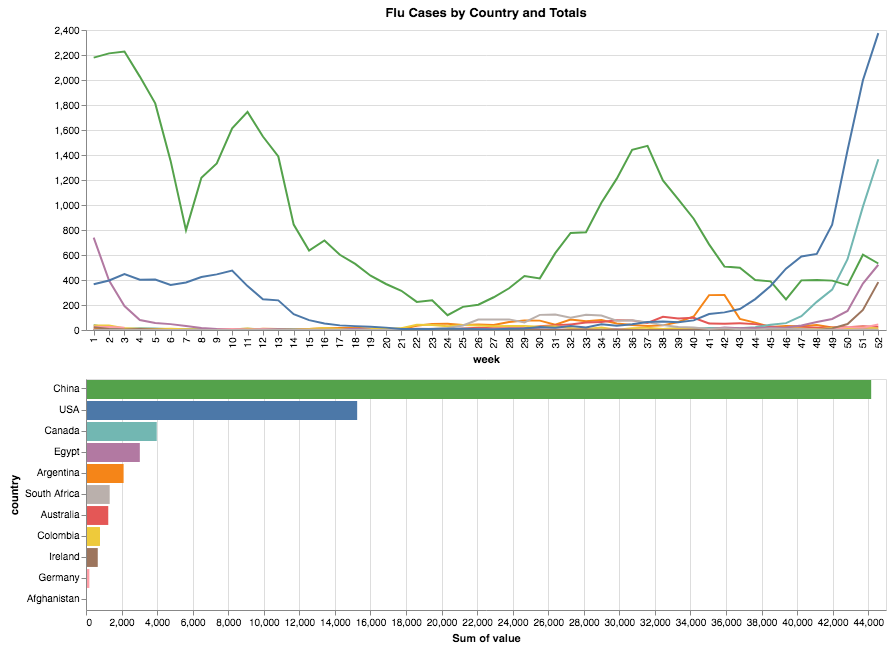

In [133]:
barclick = alt.selection_multi(encodings=['color'])

line = alt.Chart(normed).mark_line().encode(
    x='week:N',
    y=alt.X('value:Q', title=None),
    color=alt.Color('country:N', legend=None),
).transform_filter(
    barclick
).properties(
    width=800,
    title='Flu Cases by Country and Totals',
    selection=barclick
)

bar = alt.Chart(normed).mark_bar().encode(
    x='sum(value):Q',
    y=alt.Y('country:N', sort=alt.SortField(field="value", op="sum", order='descending')),
    color=alt.condition(barclick, alt.Color('country:N', legend=None), alt.value('lightgray'))
).properties(
    width=800,
    selection=barclick
)

line & bar

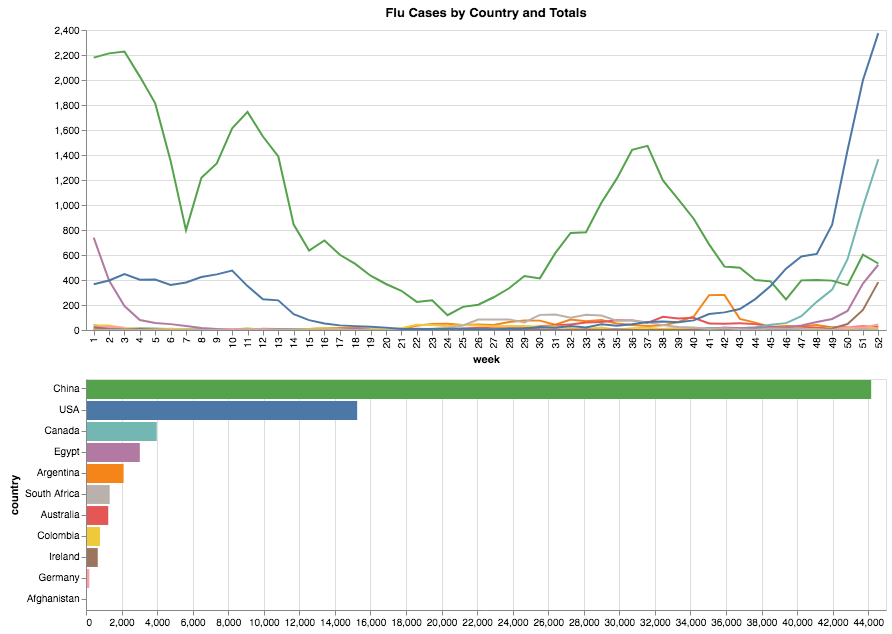

In [134]:
plot_brush = alt.selection_interval(encodings=['x'])

line = alt.Chart(normed).mark_line().encode(
    x='week:N',
    y=alt.X('value:Q', title=None),
    color=alt.Color('country:N', legend=None),
).properties(
    width=800,
    title='Flu Cases by Country and Totals',
    selection=plot_brush
)

bar = alt.Chart(normed).mark_bar().encode(
    x=alt.X('sum(value):Q', title=None),
    y=alt.Y('country:N', sort=alt.SortField(field="value", op="sum", order='descending')),
    color=alt.Color('country:N', legend=None)
).transform_filter(
    plot_brush
).properties(
    width=800,
)

line & bar

## Visualization 4
#### Create a Choropleth Map Showing Flu Cases per Country

Selection in geoplots isn't well supported. I tried several strategies below, and had to manually enter some 'ids' for the countries in question. The last plot has no flu data and was just an experiment.

In [135]:
from vega_datasets import data

countries = alt.topo_feature(data.world_110m.url, 'countries')

In [136]:
country = normed.country.unique()
country

array(['Afghanistan', 'Argentina', 'Australia', 'Canada', 'China',
       'Colombia', 'Egypt', 'Germany', 'Ireland', 'South Africa', 'USA'], dtype=object)

In [137]:
# GeoJSON ids (looked up for each country)
ids = [4, 32, 36, 124, 156, 170, 818, 276, 372, 710, 840]
dictionary = dict(zip(country, ids))
dictionary

{'Afghanistan': 4,
 'Argentina': 32,
 'Australia': 36,
 'Canada': 124,
 'China': 156,
 'Colombia': 170,
 'Egypt': 818,
 'Germany': 276,
 'Ireland': 372,
 'South Africa': 710,
 'USA': 840}

In [138]:
normed_geo = normed
normed_geo['id'] = normed_geo['country'].map(dictionary)
normed_geo.head()

,week,continent,country,value,id
0,1,Asia,Afghanistan,5.0,4
1,2,Asia,Afghanistan,13.0,4
2,3,Asia,Afghanistan,4.0,4
3,4,Asia,Afghanistan,0.0,4
4,5,Asia,Afghanistan,0.0,4


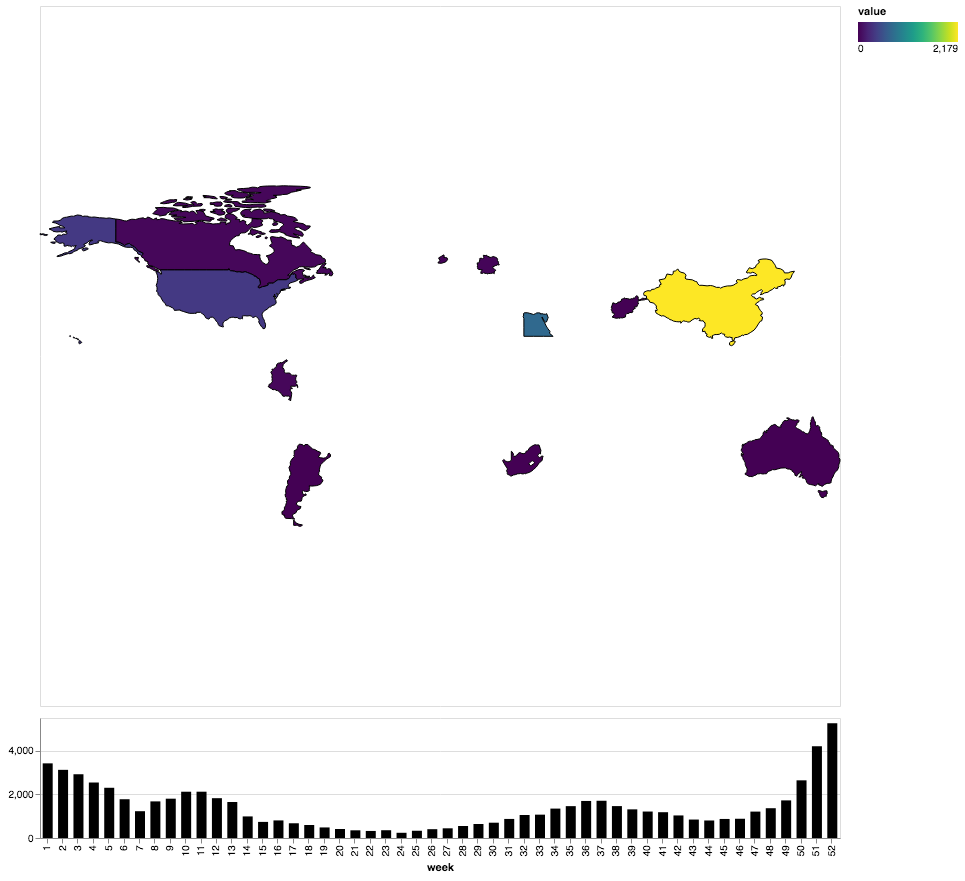

In [139]:
week = normed_geo[normed_geo['week'] == 1]

click = alt.selection_single(encodings=['x'])

values = alt.Chart(countries).mark_geoshape(
    stroke='black'
).encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(week, 'id', ['value'])
).properties(
    width=800,
    height=700
).project(
    type='equirectangular'
).repeat(
    row=['value']
).resolve_scale(
    color='independent'
)

# Not functional
hist = alt.Chart(normed).mark_bar(size=10).encode(
    x=alt.X('week:N'),
    y=alt.Y('sum(value):Q', title=None),
    color=alt.condition(click, alt.value('black'), alt.value('lightgray')),
).properties(
    width=800,
    height=120,
    selection=click
)

values & hist

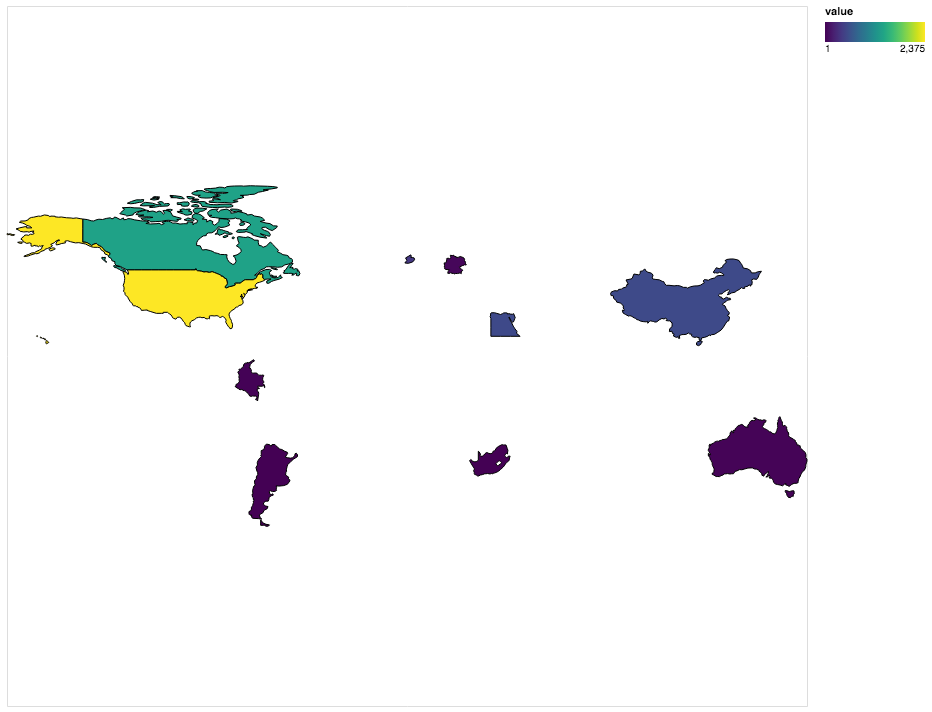

In [140]:
week52 = normed_geo[normed_geo['week'] == 52]

click = alt.selection_single(encodings=['x'])

values = alt.Chart(countries).mark_geoshape(
    stroke='black'
).encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(week52, 'id', ['value'])
).properties(
    width=800,
    height=700
).project(
    type='equirectangular'
).repeat(
    row=['value']
).resolve_scale(
    color='independent'
)
values

In [141]:
import geopandas as gpd
import json

In [176]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]

In [177]:
# Data transformations to get Quarter Columns
i = 0
for x in range(4): 
    start = x*13
    end = start+13
    
    quarter = normed.query(str(start) + '<= week <=' + str(end))
    totals = quarter.groupby('country').sum()['value']
    countries = normed.country.unique()
    col = dict(zip(countries, totals))
    col['United States'] = col.pop('USA')

    world['Q'+str(x+1)] = world['name'].map(col)

world = world.fillna(0)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Q1,Q2,Q3,Q4
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",25.0,1.0,0.0,0.0
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,0.0,0.0,0.0,0.0
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",0.0,0.0,0.0,0.0
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",0.0,0.0,0.0,0.0
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,60.0,308.0,800.0,1062.0


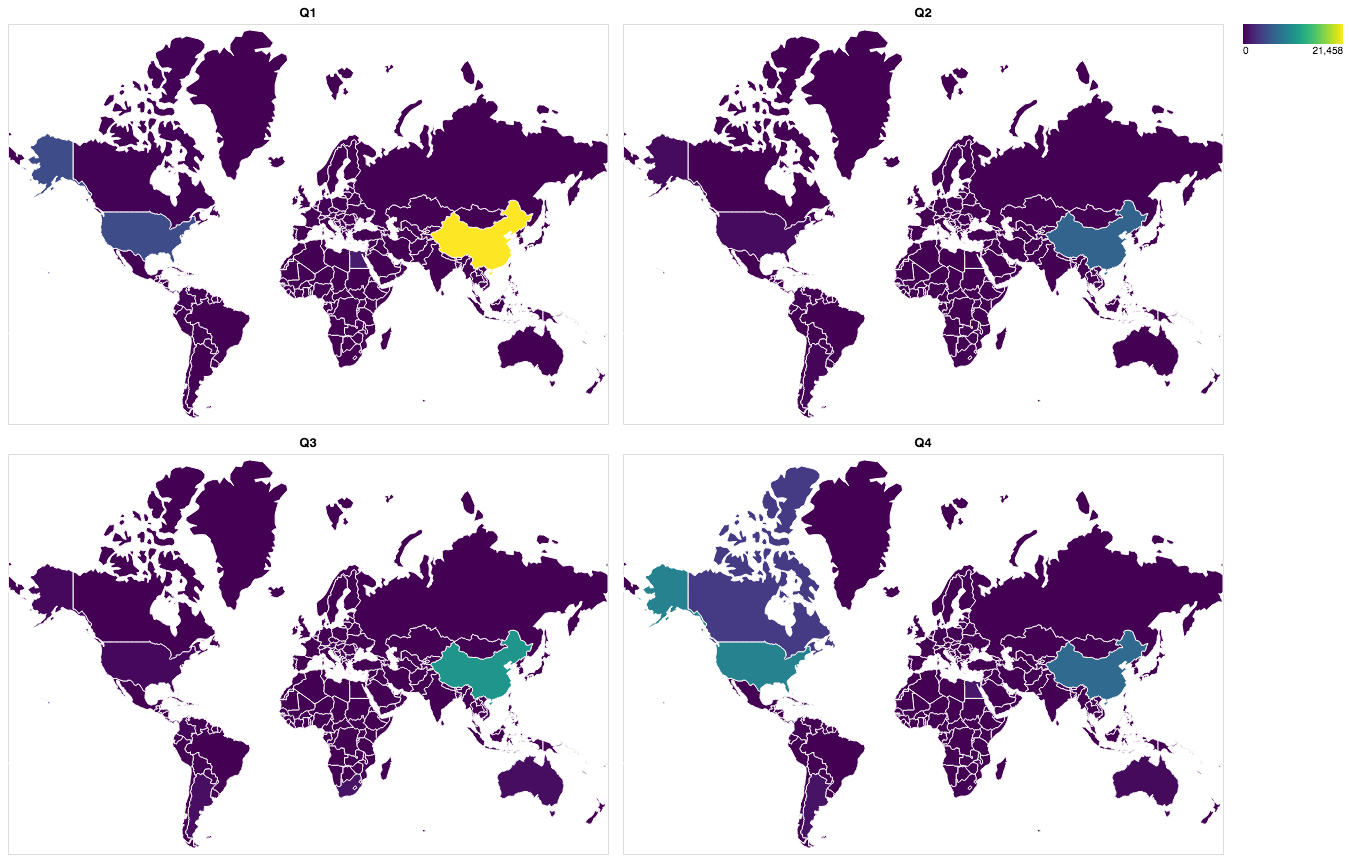

In [178]:
data  = alt.InlineData(
    values = world.to_json(), #geopandas to geojson string
    # root object type is "FeatureCollection" but we need its features
    format = alt.DataFormat(property='features',type='json')
) 

base = alt.Chart(data).mark_geoshape(
    fill='#666666',
    stroke='white'
).properties(
    width=600,
    height=400
)

quarters = ['Q1', 'Q2', 'Q3', 'Q4']

charts = [
    base.encode(
        color=alt.Color('properties.'+str(quarter)+':Q', title=None),
        tooltip=['properties.name:N', 'properties.'+str(quarter)+':Q']
    ).properties(title=quarter)
    for quarter in quarters
]

alt.vconcat(
    alt.hconcat(*charts[:2]),
    alt.hconcat(*charts[2:])
)
